In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import label_binarize

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20

# Paths
MODEL_SAVE_PATH = '../models/lens_multiclass_cnn.pth'
TRAIN_PATH = '../dataset/train'
VAL_PATH = '../dataset/val'
CLASS_NAMES = ['no', 'sphere', 'vort']

Using device: cuda:0


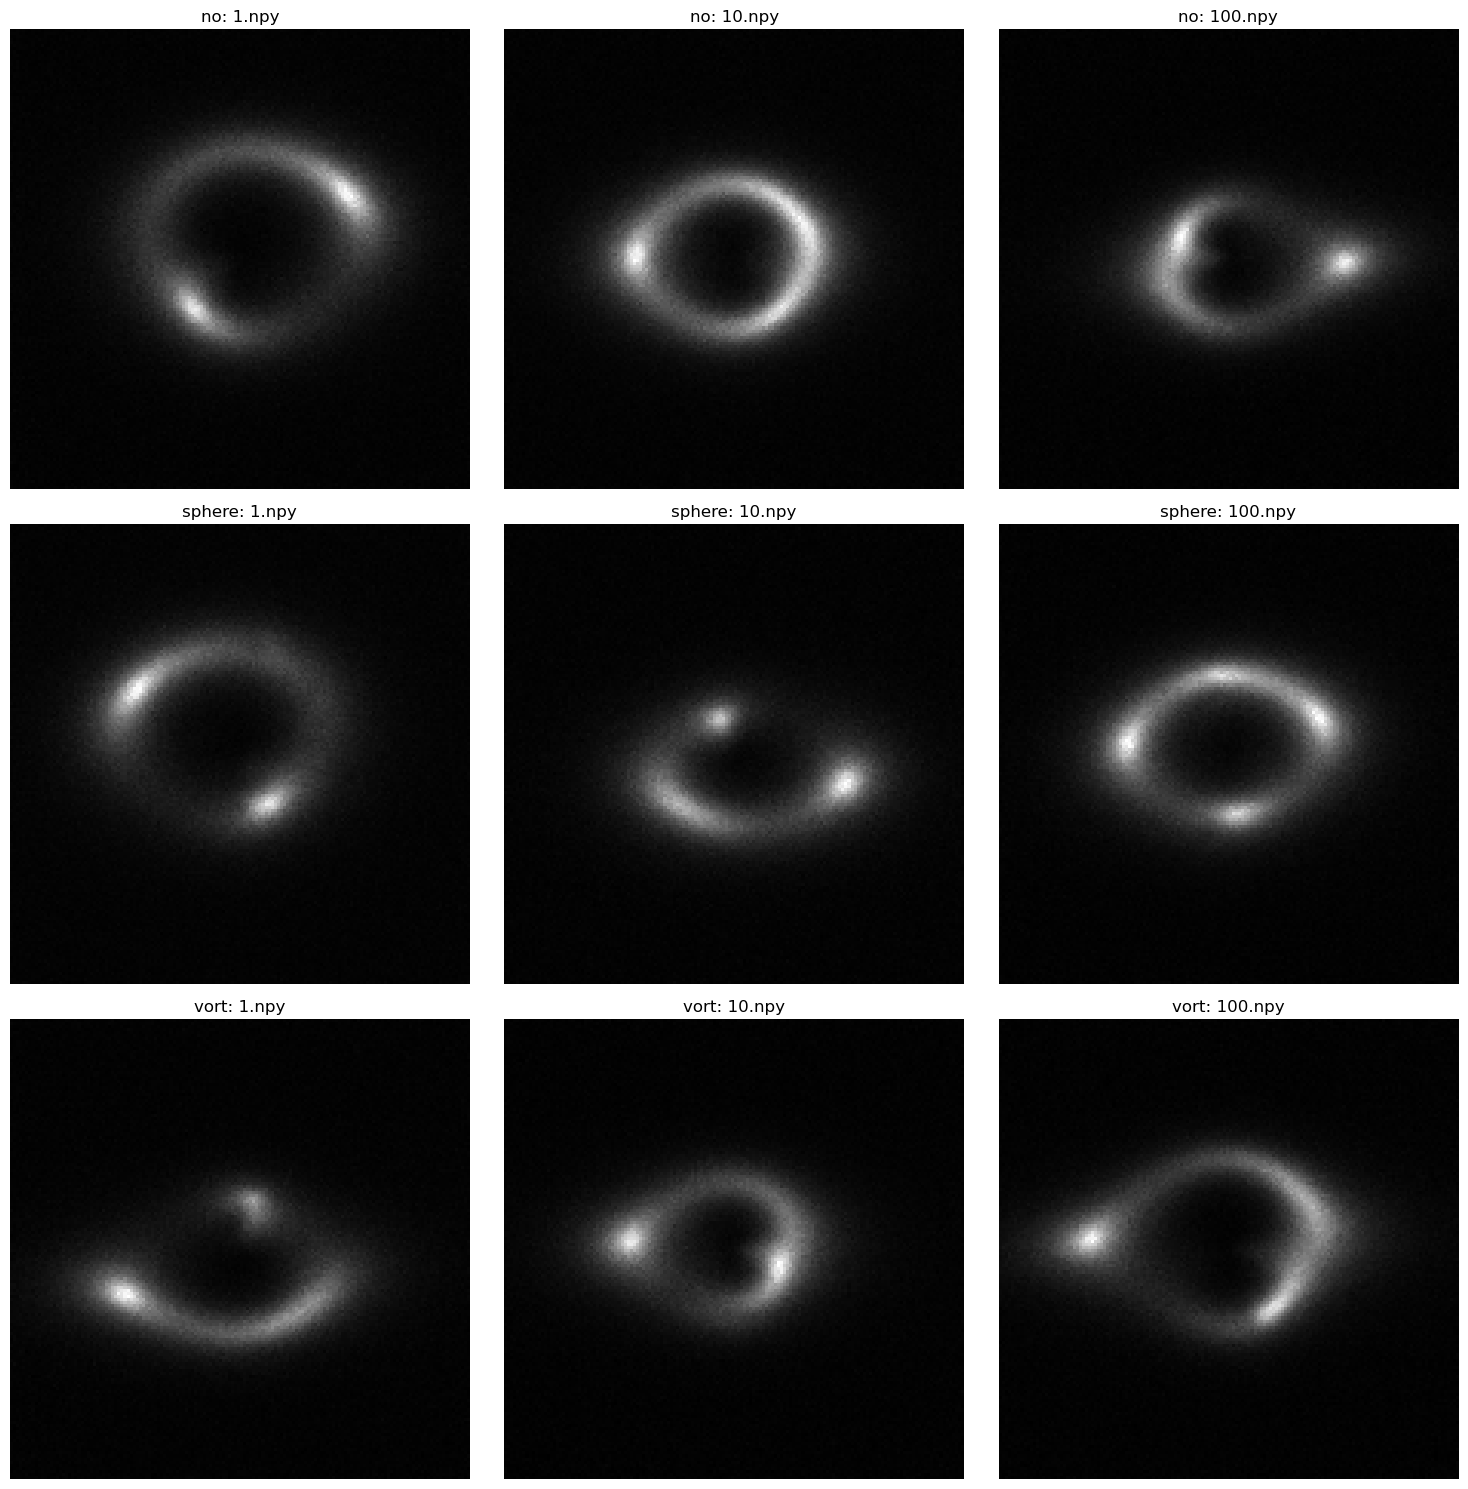

In [8]:
def visualize_sample_images(data_dir, class_names, num_samples=3):
    """Visualize sample images from each class"""
    plt.figure(figsize=(15, 5*len(class_names)))
    
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        files = os.listdir(class_dir)[:num_samples]
        
        for j, file_name in enumerate(files):
            img_path = os.path.join(class_dir, file_name)
            img = np.load(img_path)
            
            # Handle different image formats (different shapes)
            if len(img.shape) == 3:  # (C, H, W)
                img = np.transpose(img, (1, 2, 0))  # Convert to (H, W, C)
            
            # Normalize for display
            img = (img - img.min()) / (img.max() - img.min())
            
            plt.subplot(len(class_names), num_samples, i*num_samples + j + 1)
            if len(img.shape) == 2 or img.shape[2] == 1:  # Grayscale
                plt.imshow(img, cmap='gray')
            else:  # RGB
                plt.imshow(img)
            plt.title(f"{class_name}: {file_name}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('../results/sample_images_multiclass.png')
    plt.show()

# Visualize samples
visualize_sample_images(TRAIN_PATH, CLASS_NAMES)


In [9]:
class LensMultiClassDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = ['no', 'sphere', 'vort']
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}
        
        self.samples = []
        for class_name in self.class_names:
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith('.npy'):
                    self.samples.append((os.path.join(class_dir, filename), self.class_to_idx[class_name]))
        
        # Print class distribution
        self.class_counts = {cls: 0 for cls in self.class_names}
        for _, label in self.samples:
            self.class_counts[self.class_names[label]] += 1
        
        print(f"Dataset from {root_dir}:")
        for cls in self.class_names:
            print(f"  {cls}: {self.class_counts[cls]} samples")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        data = np.load(img_path)
        
        # Check and standardize image format
        # If image is (H, W), add channel dimension
        if len(data.shape) == 2:
            data = data[..., np.newaxis]
            data = np.transpose(data, (2, 0, 1))  # Convert to (C, H, W)
        # If image is (H, W, C), convert to (C, H, W)
        elif len(data.shape) == 3 and data.shape[0] != 1 and data.shape[0] != 3:
            data = np.transpose(data, (2, 0, 1))
        
        # Convert to float tensor
        data = torch.tensor(data, dtype=torch.float32)
        
        # Apply transformations if available
        if self.transform:
            data = self.transform(data)
        
        return data, label

In [10]:
# Define transformations
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create datasets
train_dataset = LensMultiClassDataset(TRAIN_PATH, transform=transform)
val_dataset = LensMultiClassDataset(VAL_PATH, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Check the shape of a sample
sample_data, _ = train_dataset[0]
print(f"Sample shape: {sample_data.shape}")

Dataset from ../dataset/train:
  no: 10000 samples
  sphere: 10000 samples
  vort: 10000 samples
Dataset from ../dataset/val:
  no: 2500 samples
  sphere: 2500 samples
  vort: 2500 samples
Training samples: 30000
Validation samples: 7500
Sample shape: torch.Size([1, 150, 150])


In [11]:
class LensMultiClassCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(LensMultiClassCNN, self).__init__()
        
        # Determine input channels from the sample
        sample_data, _ = train_dataset[0]
        input_channels = sample_data.shape[0]
        
        # Feature extraction
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
        )
        
        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Calculate feature size based on sample
        with torch.no_grad():
            x = self.features(sample_data.unsqueeze(0))
            x = self.adaptive_pool(x)
            feature_size = x.view(1, -1).shape[1]
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(feature_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [12]:
# Initialize model and move to GPU
model = LensMultiClassCNN(num_classes=len(CLASS_NAMES)).to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)



LensMultiClassCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.25, inplace=False)
  )
  (adaptive_pool): Adaptive

In [13]:
# Training and Validation Functions

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = 100 * correct / total
    
    return val_loss, val_acc

In [ ]:
# Training Loop

def train_model():
    # For tracking metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    
    for epoch in range(EPOCHS):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Print stats
        print(f"Epoch [{epoch+1}/{EPOCHS}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Model saved at epoch {epoch+1}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('../results/training_history_multiclass.png')
    plt.show()
    
    return train_losses, train_accuracies, val_losses, val_accuracies

# Run training
history = train_model()

In [ ]:
# Evaluation Functions

def compute_multiclass_roc_auc(model, dataloader):
    """Compute ROC curve and AUC for multiclass classification"""
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Binarize labels for multi-class ROC
    n_classes = len(CLASS_NAMES)
    binarized_labels = label_binarize(all_labels, classes=range(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(binarized_labels.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    return fpr, tpr, roc_auc, all_labels, all_probs

In [ ]:
def plot_confusion_matrix(true_labels, predictions):
    """Plot confusion matrix"""
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('../results/confusion_matrix_multiclass.png')
    plt.show()
    
    print("Classification Report:")
    print(classification_report(true_labels, predictions, target_names=CLASS_NAMES))

def plot_roc_curves(fpr, tpr, roc_auc):
    """Plot ROC curves for each class"""
    plt.figure(figsize=(10, 8))
    
    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
            label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
            color='deeppink', linestyle=':', linewidth=4)
    
    # Plot ROC curves for each class
    colors = ['blue', 'red', 'green']
    for i, color, class_name in zip(range(len(CLASS_NAMES)), colors, CLASS_NAMES):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'ROC for {class_name} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multi-class Classification')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('../results/roc_curves_multiclass.png')
    plt.show()

def visualize_predictions(model, dataloader, num_samples=8):
    """Visualize model predictions on sample images"""
    model.eval()
    
    # Get batch of images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    # Get predictions
    images_gpu = images.to(device)
    with torch.no_grad():
        outputs = model(images_gpu)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    # Convert to numpy
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()
    probs = probs.cpu().numpy()
    
    # Plot images with predictions
    fig, axes = plt.subplots(2, num_samples//2, figsize=(15, 6))
    axes = axes.flatten()
    
    for i in range(num_samples):
        # Get image
        img = images[i]
        
        # Convert from (C, H, W) to (H, W, C) for displaying
        if img.shape[0] in [1, 3]:
            img = np.transpose(img, (1, 2, 0))
        
        # For single channel, squeeze to 2D
        if img.shape[-1] == 1:
            img = np.squeeze(img)
            
        # Normalize for display
        img = (img - img.min()) / (img.max() - img.min())
        
        # Display
        if len(img.shape) == 2:
            axes[i].imshow(img, cmap='gray')
        else:
            axes[i].imshow(img)
            
        # Set title (green if correct, red if wrong)
        color = 'green' if predicted[i] == labels[i] else 'red'
        axes[i].set_title(f"True: {CLASS_NAMES[labels[i]]}\nPred: {CLASS_NAMES[predicted[i]]}\nProb: {probs[i][predicted[i]]:.2f}", 
                         color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('../results/sample_predictions_multiclass.png')
    plt.show()

In [ ]:
# Load best model if exists
if os.path.exists(MODEL_SAVE_PATH):
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    print("Loaded best model for evaluation")

# Compute ROC and AUC
fpr, tpr, roc_auc, true_labels, all_probs = compute_multiclass_roc_auc(model, val_loader)

# Get predictions from probabilities
predictions = np.argmax(all_probs, axis=1)

# Print AUC scores
print("AUC Scores:")
for i, class_name in enumerate(CLASS_NAMES):
    print(f"{class_name}: {roc_auc[i]:.4f}")
print(f"Micro-average: {roc_auc['micro']:.4f}")

In [ ]:
# Plot ROC curves
plot_roc_curves(fpr, tpr, roc_auc)



In [ ]:
# Plot confusion matrix
plot_confusion_matrix(true_labels, predictions)


In [ ]:

# Visualize sample predictions
visualize_predictions(model, val_loader)